The type of features required by each algorithm can vary, but some general guidelines are:

Time-series forecasting algorithms: These algorithms typically work well with time-series data and require a series of historical sales data as input features.

Regression algorithms: These algorithms require both input (predictor) and output (response) features. The input features could be lagged sales data, macroeconomic indicators, holiday information, and others. The output feature is the target variable, which is the sales data to be predicted.

Neural network-based algorithms: These algorithms require a large number of input features, and the input features can include both numerical and categorical data. The input data must be preprocessed and transformed into a suitable format for the algorithm, such as using one-hot encoding for categorical features.

It is important to note that feature engineering is a crucial step in the process of using these algorithms for sales forecasting, as the quality of the features can significantly impact the performance of the model.

Here is an example configuration for time-series forecasting using the ARIMA algorithm:

Data preparation: Prepare the time-series data by ensuring that it is stationary, meaning that the mean and variance are constant over time. This can be achieved by removing any trends and seasonality present in the data.

Model selection: Choose the appropriate ARIMA model by determining the order of differencing (d), the order of the autoregressive term (p), and the order of the moving average term (q). These parameters can be selected using methods such as the Augmented Dickey-Fuller test and the ACF/PACF plots.

Model fitting: Fit the ARIMA model to the stationary time-series data using the selected order of differencing, autoregressive, and moving average terms.

Model evaluation: Evaluate the performance of the ARIMA model using metrics such as mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE).

Model prediction: Use the fitted ARIMA model to make predictions on the future sales data.

Note: The configuration will vary depending on the specific requirements of the problem and the choice of time-series forecasting algorithm, but the steps outlined above provide a general idea of the process.

In [1]:
import pyodbc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering 1-2-23.csv', delimiter= ";")
df = df[(df["Letra cluster"] == "A") | (df["Letra cluster"] == "B")]
df_10_ag = df[df["Distrito-Nombretipozona"] == '10-Artes graficas']

In [10]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [11]:
nit_cliente = "'800226417-1'"
# nit_cliente = "'900085929-1'"
# nit_cliente = "'900173543-1'"

In [12]:
fecha_final = "'2023-01-31'"

In [13]:
codigo_SQL = f"SELECT DATEFROMPARTS(VTAANO, VTAMES, 1) AS 'Fecha', SUM(VTAVLRVTA) AS 'Ventas' FROM V_VTA_VTAHEC WHERE CONCAT(CONCAT(VTANIT, '-'), VTASUC) = {nit_cliente} AND VTAFCH < {fecha_final} GROUP BY DATEFROMPARTS(VTAANO, VTAMES, 1)"

In [14]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df_SQL = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
df_SQL["Ventas"] = df_SQL["Ventas"].astype(int)
df_SQL["Fecha"] = pd.to_datetime(df_SQL["Fecha"])
df_SQL = df_SQL.set_index("Fecha")

In [20]:
# Make the data stationary by removing any trends and seasonality
df_diff = df_SQL.diff(periods= 1)
df_diff.dropna(inplace= True)

In [ ]:
# 1. Data preparation

import pandas as pd
import numpy as np

# Load the time-series data
data = pd.read_csv("sales_data.csv")

# Convert the data into a time-series format
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")

# Make the data stationary by removing any trends and seasonality
data_diff = data.diff(periods=1)
data_diff.dropna(inplace=True)


<Figure size 640x480 with 0 Axes>

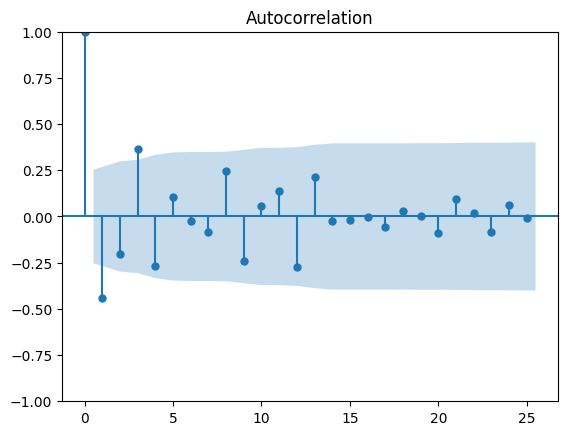

<Figure size 640x480 with 0 Axes>

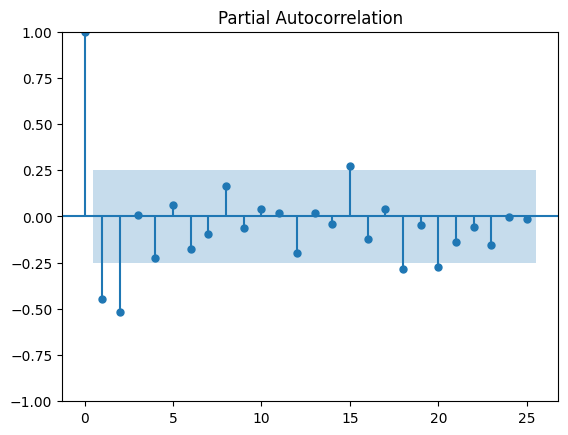

In [23]:
# 2. Model selection

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot the autocorrelation function (ACF) to determine the order of the autoregressive term (
plt.figure()
plot_acf(df_diff, lags=25)
plt.show()

# Plot the partial autocorrelation function (PACF) to determine the order of the moving average term (q)
plt.figure()
plot_pacf(df_diff, lags=25)
plt.show()


ADF Statistic: -3.754914
p-value: 0.003404


<Figure size 640x480 with 0 Axes>

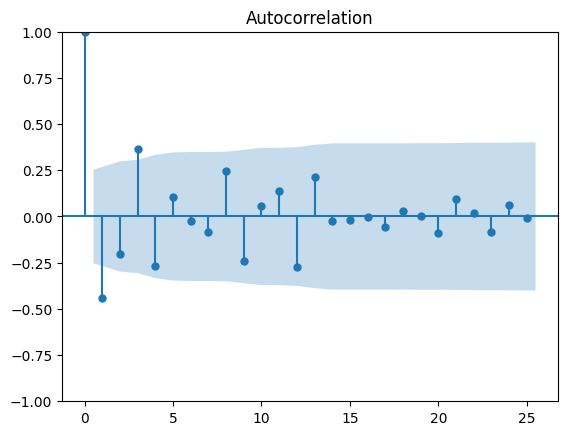

<Figure size 640x480 with 0 Axes>

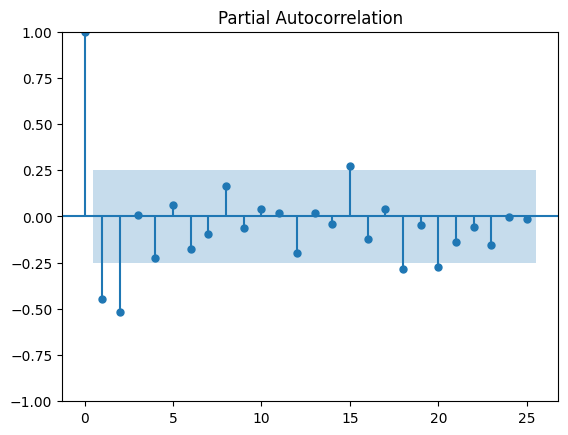

In [26]:
# 2.1 Model selection
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Test the stationarity of the time-series data using the Augmented Dickey-Fuller test
result = adfuller(df_diff["Ventas"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Plot the autocorrelation function (ACF) to determine the order of the autoregressive term (p)
plt.figure()
plot_acf(df_diff, lags=25)
plt.show()

# Plot the partial autocorrelation function (PACF) to determine the order of the moving average term (q)
plt.figure()
plot_pacf(df_diff, lags=25)
plt.show()


In [71]:
# 3. model fitting
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model to the stationary time-series data
model = ARIMA(df_SQL, order=(2,0,3))
model_fit = model.fit()


In [75]:
# 4. Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score, mean_absolute_percentage_error

future_dates = ['2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01']
n_test = 4

# Predict the values using the fitted model
predictions = model_fit.predict(start=len(df_diff), end=len(df_diff)+len(future_dates)-1, typ='levels')

# Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(df_SQL[-n_test:], predictions)
mse = mean_squared_error(df_SQL[-n_test:], predictions)
mape = mean_absolute_percentage_error(df_SQL[-n_test:], predictions)
print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("MAPE: ", mape)


Mean Absolute Error:  73467712.98033373
Mean Squared Error:  6715710197554472.0
MAPE:  0.8359837429795997


In [73]:
# 5. Model prediction
# Generate predictions for future dates
n_future = 4
future_dates = pd.date_range(df_SQL.index[-1], periods=n_future, freq='D')
future_predictions = model_fit.predict(start=len(df_diff), end=len(df_diff)+len(future_dates)-1, typ='levels')


In [74]:
future_predictions

2023-01-01    1.681405e+08
2023-02-01    1.523099e+08
2023-03-01    2.293964e+08
2023-04-01    1.147669e+08
Freq: MS, Name: predicted_mean, dtype: float64

In [34]:
future_predictions

2023-01-01    1.926027e+08
2023-02-01    1.020739e+08
2023-03-01    1.215394e+08
2023-04-01    1.269524e+08
Freq: MS, Name: predicted_mean, dtype: float64

In [35]:
df_SQL

,Ventas
Fecha,
2018-01-01,120860978
2018-02-01,170202152
2018-03-01,54935586
2018-04-01,52677861
2018-05-01,65472805
...,...
2022-09-01,153077032
2022-10-01,218037069
2022-11-01,185362625


In [58]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [40]:
# Load data and perform preprocessing if necessary
df_SQL = df_SQL

n_train = int(round(df_SQL.shape[0] * 0.8, 0))
n_train

# Split data into training and testing sets
train = df_SQL[:n_train]
test = df_SQL[n_train:]

In [65]:
# Define the performance metric
def evaluate_arima_model(data, arima_order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    return mse

In [44]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {'order': [(p, d, q) for p in range(5) for d in range(2) for q in range(5)]}

In [53]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order):
        self.order = order
        
    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.model_fit = self.model.fit()
        return self
        
    def predict(self, X):
        return self.model_fit.predict(start=len(X), end=len(X))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y - y_pred) ** 2)

In [66]:
# Use RandomizedSearchCV to find the best hyperparameters
arima_model = ARIMAWrapper(order=(1,1,1))
# arima = GridSearchCV(arima_model, param_grid, scoring=evaluate_arima_model, cv=5)
arima = RandomizedSearchCV(arima_model, param_grid, scoring=evaluate_arima_model, cv=5)
arima_fit = arima.fit(train)

In [67]:
# Print the best ARIMA hyperparameters
print("Best ARIMA(p,d,q) = {} with MSE of {}".format(arima_fit.best_params_['order'], arima_fit.best_score_))

Best ARIMA(p,d,q) = (2, 0, 3) with MSE of nan


In [70]:
arima_fit.cv_results_

{'mean_fit_time': array([0.09088807, 0.13485889, 0.02760601, 0.01820726, 0.11375909,
        0.04667516, 0.03236165, 0.09265985, 0.0538311 , 0.09800391]),
 'std_fit_time': array([0.03604996, 0.02449524, 0.0218384 , 0.01057009, 0.02948769,
        0.01256394, 0.01661625, 0.03314102, 0.0284385 , 0.03546056]),
 'mean_score_time': array([0.00043378, 0.0004333 , 0.00024137, 0.00059853, 0.00038671,
        0.00021868, 0.00039296, 0.0006187 , 0.        , 0.0001996 ]),
 'std_score_time': array([0.00053195, 0.00053573, 0.00048275, 0.0004887 , 0.00047412,
        0.00043736, 0.00048139, 0.00081029, 0.        , 0.00039921]),
 'param_order': masked_array(data=[(2, 0, 3), (4, 1, 4), (1, 0, 2), (0, 0, 2), (4, 0, 2),
                    (1, 0, 3), (0, 0, 4), (2, 0, 4), (1, 0, 4), (3, 0, 3)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'order': (2, 0, 3)},
  {'order': (4,